In [167]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import cv2
import pandas
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import axes3d
from  PIL import Image
from time import time
from torch import nn
from torchvision import models
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.dataset import Dataset
from torchsummary import summary

from sklearn.decomposition import PCA
from sklearn import preprocessing

torch.cuda.is_available()

False

In [169]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 '

In [171]:

resnet = models.resnet50(pretrained=True)
# freeze all base layers; Parameters of newly constructed modules have requires_grad=True by default
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.fc.in_features

# add final layers tot he network
resnet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1000),
    nn.Linear(1000,3)
    )

# print(list(resnet.parameters()))



    # verify what the network end looks like
summary(resnet, input_size= (3,244,244))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

In [173]:
def load_images_from_folder(folder, end, as_tensor = False):
        
    images = []
    num_img = []
    file_count= 0
    dirnames = [] 

 

    for _, dirnames, filenames in os.walk(folder):

 

        if dirnames != []:
            subfolders = dirnames
        current_path = os.path.join(folder, subfolders[file_count])
        num_img.append(len(os.listdir(current_path)))
        for filename in os.listdir(current_path):
                if as_tensor:
                    img = cv2.imread(os.path.join(current_path, filename))
                    if img is not None:    
                        img = torch.from_numpy(img).type(torch.uint8)               
                        images.append(img)
                        
                else:
                    img = Image.open(os.path.join(current_path, filename))
                    if img is not None:    
                        images.append(img)

 

        file_count += 1
        
        if file_count % 10 == 0:
            print('number of folder done =', file_count, 'total number of images so far =', len(images))
            
        if file_count  == end:
            return images, num_img

    return images, num_img


def show_image(PIL_img):
    PIL_img.show()


In [175]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy()
    inp.transpose((0, 2, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def show_tensor_image(image_tensor, preprocess = False):
    # use this code when showing the images
    inp = image_tensor.numpy()
    if preprocess:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

    im2 = inp.copy()
    im2[:, :, 0] = image_tensor[:, :, 2]
    im2[:, :, 2] = image_tensor[:, :, 0]
    plt.imshow(im2)


In [176]:
path = r"D:\Pablo\Uni Work\uob_image_set\uob_image_set"

N_CHANNELS = 3

images, num_images = load_images_from_folder(path, 10, as_tensor= False)
# show_image(images[0])
num_images





number of folder done = 10 total number of images so far = 42


[5, 4, 4, 5, 4, 3, 4, 4, 5, 4]

In [177]:
# loading data in batches and show a grid of them
#  reconsider how to load data
# full_loader = torch.utils.data.DataLoader(images, shuffle=False, num_workers=os.cpu_count())
# print(full_loader)

#     # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [178]:
# using the mean and std values form the ImageNet data for which it was pretrained
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )])


In [179]:


def preprocess_and_batch(image_list):
    list_input_tensor = []
    list_input_batch = []
    
    for item in range(len(image_list)):
        input_tensor = preprocess(image_list[item])
        input_batch = input_tensor.unsqueeze(0)
        list_input_tensor.append(input_tensor)
        list_input_batch.append(input_batch)
    return list_input_batch, list_input_tensor

list_input_batch, list_input_tensor= preprocess_and_batch(images)
print(list_input_batch)


, 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          ...,
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400]]]]), tensor([[[[

In [149]:

def feed_batch_to_network(list_input_batch, network):
    output_array = []
    for i in range(len(list_input_batch)):
        if torch.cuda.is_available():
            input_batch = list_input_batch[i].to('cuda')
            resnet.to('cuda')
        else:
            input_batch = list_input_batch[i].to('cpu')
            resnet.to('cpu')
            
        with torch.no_grad():
            output = network(input_batch)
            cpu_tensor = output.cpu()
            pos = cpu_tensor[0].tolist()       
            output_array.append(pos)
    output_array = np.asarray(output_array)
    display(output_array)


    return output_array


network_output = feed_batch_to_network(list_input_batch, resnet)
print(network_output)


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [147]:
output_array = []
for i in range(len(list_input_batch)):
    if torch.cuda.is_available():
        input_batch = list_input_batch[i].to('cuda')
        resnet.to('cuda')
    else:
        input_batch = list_input_batch[i].to('cpu')
        resnet.to('cpu')
        
    with torch.no_grad():
        output = resnet(input_batch)
        cpu_tensor = output.cpu()
        print(cpu_tensor.tolist())    
    output_array.append(cpu_tensor[0].tolist())
    output_array = np.asarray(output_array)
    print(output_array)
    display(output_array)


[[0.42411547899246216, 0.22404983639717102, 0.28983622789382935]]
[[0.42411548 0.22404984 0.28983623]]


array([[0.42411548, 0.22404984, 0.28983623]])

[[0.4168035387992859, 0.21299374103546143, 0.3017503023147583]]


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [131]:
network_output

array([[0.41841465, 0.20298707, 0.29708844]])

[0.41841465]


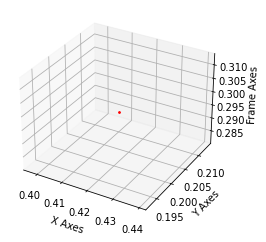

In [133]:

def output_3d_plot(num_images):

    fig = plt.figure()
    ax = plt.axes(projection="3d")

    img_counter = 0
    for n in num_images:
        r = lambda: random.randint(0,255)
        random_color = '#%02X%02X%02X' % (r(),r(),r())
        ax.scatter(network_output[img_counter:img_counter + n,0], network_output[img_counter:img_counter + n,1], network_output[img_counter:img_counter + n,2],color=random_color,s=20)
        img_counter += n


    ax.set_xlabel('X Axes')
    ax.set_ylabel('Y Axes')
    ax.set_zlabel('Frame Axes')

    plt.show()


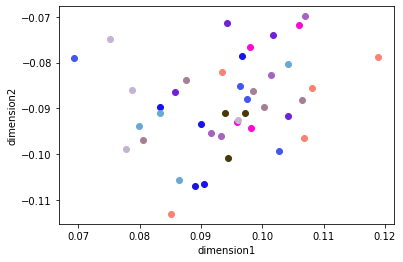

In [200]:
def output_2d_plot(network_output,num_images, dimension_1, dimension_2):
    # dimension numbers = 0, 1, 2
    fig = plt.figure()
    img_counter = 0
    for n in num_images:
        r = lambda: random.randint(0,255)
        random_color = '#%02X%02X%02X' % (r(),r(),r())
        plt.plot(network_output[img_counter:img_counter + n,dimension_1],network_output[img_counter:img_counter + n,dimension_2], 'o',color=random_color)
        img_counter += n
    plt.xlabel("dimension1")
    plt.ylabel("dimension2")
    plt.show()            
output_2d_plot(network_output,num_images, 0, 1)

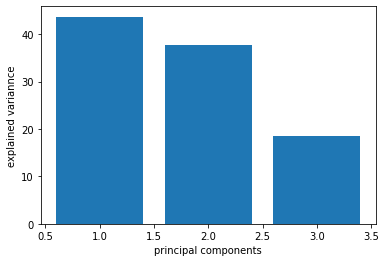

In [201]:
scaled_data = preprocessing.scale(network_output)
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
per_var

labels = ['PC' +  str(x) for x in range(1,len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.xlabel("principal components")
plt.ylabel("explained variannce")
plt.show()

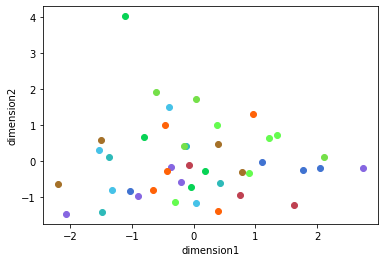

In [199]:

pca_df = pd.DataFrame(pca_data, columns=labels)

def pca_2d_plot(pca_df, num_images, dimension_1, dimension_2):
    fig = plt.figure()
    img_counter = 0
    for n in num_images:
        r = lambda: random.randint(0,255)
        random_color = '#%02X%02X%02X' % (r(),r(),r())
        plt.plot(dimension_1[img_counter:img_counter + n], dimension_2[img_counter:img_counter + n], 'o',color=random_color)
        img_counter += n
    plt.xlabel("dimension1")
    plt.ylabel("dimension2")
    plt.show()
pca_2d_plot(pca_df, num_images, pca_df.PC1,  pca_df.PC2)